In [ ]:
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('El usuario subió el archivo "{name}" con longitud {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving SN_d_tot_V2.0-2011-2024.csv to SN_d_tot_V2.0-2011-2024.csv
El usuario subió el archivo "SN_d_tot_V2.0-2011-2024.csv" con longitud 153751 bytes


In [ ]:
import pandas as pd
df = pd.read_csv('SN_d_tot_V2.0-2011-2024.csv')
df_one_per_month = df[df['day'] == 1]
df_two_per_month = df[(df['day'] == 1) | (df['day'] == 15)]
df_four_per_month = df[(df['day'] == 7) | (df['day'] == 14) | (df['day'] == 21) | (df['day'] == 28)]
df_four_per_month

,year,month,day,date in fraction of year,sn number,standard deviation,observations,definitive/provisional
6,2011,1,7,2011018,35,3.1,11,1
13,2011,1,14,2011037,0,2.0,8,1
20,2011,1,21,2011056,33,3.8,13,1
27,2011,1,28,2011075,13,3.3,18,1
37,2011,2,7,2011103,15,2.8,20,1
...,...,...,...,...,...,...,...,...
4775,2024,1,28,2024075,68,10.8,26,0
4785,2024,2,7,2024102,150,26.1,27,0
4792,2024,2,14,2024122,143,15.6,20,0
4799,2024,2,21,2024141,51,8.7,21,0


In [ ]:
# prompt: usa df_one_per_month y dime su valor máximo y mínimo

from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  print('El usuario subió el archivo "{name}" con longitud {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
df = pd.read_csv('SN_d_tot_V2.0-2011-2024.csv')
df_one_per_month = df[df['day'] == 1]

# Calculate and print the maximum and minimum values of a specific column
# Replace 'column_name' with the actual column name you want to analyze
column_name = 'sn number'  # Example column name; change as needed
if column_name in df_one_per_month.columns:
    max_value = df_one_per_month[column_name].max()
    min_value = df_one_per_month[column_name].min()
    print(f"Valor máximo de '{column_name}': {max_value}")
    print(f"Valor mínimo de '{column_name}': {min_value}")
else:
    print(f"La columna '{column_name}' no se encuentra en el DataFrame.")

Saving SN_d_tot_V2.0-2011-2024.csv to SN_d_tot_V2.0-2011-2024 (2).csv
El usuario subió el archivo "SN_d_tot_V2.0-2011-2024 (2).csv" con longitud 153751 bytes
Valor máximo de 'sn number': 180
Valor mínimo de 'sn number': 0


## X sunspots por mes de 2011 a 2024

In [ ]:
import os
import aiohttp
import asyncio
from bs4 import BeautifulSoup
import html5lib
import urllib.request

# Directorio para guardar las imágenes
folder = 'training_images_4'
os.makedirs(folder, exist_ok=True)

# Función para descargar imágenes
async def download_image(sn_n, df_filtrado, folder):
    if df_filtrado.empty:
        print(f"No se encontraron datos para el número de mancha solar {sn_n}")
        return

    folder2 = os.path.join(folder, str(sn_n))
    os.makedirs(folder2, exist_ok=True)

    tasks = []
    for _, row in df_filtrado.iterrows():
        # Asegurarse de que los valores sean enteros
        year = int(row['year'])
        month = str(int(row['month'])).zfill(2)  # Convertir a entero y rellenar con ceros
        day = str(int(row['day'])).zfill(2)      # Convertir a entero y rellenar con ceros

        base_url = "https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/"
        url = f"{base_url}{year}/hmiigr/{year}{month}{day}/"

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                if response.status == 200:
                    html = await response.text()
                    soup = BeautifulSoup(html, 'html5lib')
                    imagelinks = soup.find_all("a")

                    if imagelinks:
                        # Asumimos que la imagen deseada está en la posición 5 (ajusta si es necesario)
                        imagelink = imagelinks[5]['href']
                        url2 = url + imagelink
                        destination = os.path.join(folder2, imagelink)

                        # Usar asyncio.to_thread para descargar la imagen
                        task = asyncio.to_thread(urllib.request.urlretrieve, url2, destination)
                        tasks.append(task)
                        print(f'[{sn_n}] Se guardó {imagelink} de {year}-{month}-{day}')
                else:
                    print(f"[{sn_n}] No se pudo acceder al URL: {url}")

    # Ejecutar todas las descargas en paralelo
    await asyncio.gather(*tasks)

# Función principal
async def main():
    # Obtener los días deseados de cada mes
    #df_one_per_month = df[df['day'] == 1]
    #df_two_per_month = df[(df['day'] == 1) | (df['day'] == 15)]
    df_four_per_month = df[(df['day'] == 7) | (df['day'] == 14) | (df['day'] == 21) | (df['day'] == 28)]

    '''
    Fundamental cambiar el df para cada uno que se vaya a usar
    '''
    # Crear tareas para cada número de mancha solar (sn_n)
    tasks = [download_image(sn_n, df_four_per_month[df_four_per_month['sn number'] == sn_n], folder)
             for sn_n in df_four_per_month['sn number'].unique()]

    # Ejecutar todas las tareas en paralelo
    await asyncio.gather(*tasks)

# Ejecutar el bucle de eventos (por ejemplo, en Google Colab o en un entorno asíncrono)
import nest_asyncio
nest_asyncio.apply()
await main()


[52] Se guardó 20110514_000000_Ic_flat_1k.jpg de 2011-05-14
[108] Se guardó 20110921_000000_Ic_flat_1k.jpg de 2011-09-21
[62] Se guardó 20110428_000000_Ic_flat_1k.jpg de 2011-04-28
[33] Se guardó 20110121_000000_Ic_flat_1k.jpg de 2011-01-21
[43] Se guardó 20110507_000000_Ic_flat_1k.jpg de 2011-05-07
[109] Se guardó 20110928_000000_Ic_flat_1k.jpg de 2011-09-28
[51] Se guardó 20110228_000000_Ic_flat_1k.jpg de 2011-02-28
[81] Se guardó 20110407_000000_Ic_flat_1k.jpg de 2011-04-07
[87] Se guardó 20110214_000000_Ic_flat_1k.jpg de 2011-02-14
[35] Se guardó 20110107_000000_Ic_flat_1k.jpg de 2011-01-07
[147] Se guardó 20131028_000000_Ic_flat_1k.jpg de 2013-10-28
[0] Se guardó 20110114_000000_Ic_flat_1k.jpg de 2011-01-14
[53] Se guardó 20121028_000000_Ic_flat_1k.jpg de 2012-10-28
[80] Se guardó 20110421_000000_Ic_flat_1k.jpg de 2011-04-21
[47] Se guardó 20110221_000000_Ic_flat_1k.jpg de 2011-02-21
[37] Se guardó 20130121_000000_Ic_flat_1k.jpg de 2013-01-21
[123] Se guardó 20110414_043000_Ic_fla

# Preprocesamiento de imágenes

Opción 1: Usando datagen

In [ ]:
# Es el mismo procesado anterior, pero almacenando las imágenes en 512*512 pixeles

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de datos con reescalado
datagen = ImageDataGenerator(rescale=1./255)

# Cargar las imágenes del directorio
generator = datagen.flow_from_directory(
    directory='/content/training_images_4',
    target_size=(512, 512),
    batch_size=10,
    class_mode='sparse'
)

Found 158 images belonging to 91 classes.


Opción 2: Usando x_train, y_train, x_test, y_test

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf

# Directorio de las imágenes
data_dir = '/content/training_images_4'

# Parámetros del procesamiento
target_size = (512, 512)

# Función para cargar imágenes y etiquetas desde carpetas
def load_images_and_labels_from_folders(data_dir, target_size):
    images = []
    labels = []

    # Recorrer cada carpeta en el directorio principal
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Validar que sea un directorio
        if not os.path.isdir(folder_path):
            continue

        try:
            # Convertir el nombre de la carpeta a un valor flotante (etiqueta de regresión)
            label = float(folder_name)
        except ValueError:
            print(f"Carpeta {folder_name} no representa un valor numérico. Ignorada.")
            continue

        # Recorrer las imágenes dentro de la carpeta
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)

            try:
                # Cargar y preprocesar la imagen
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalización
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"No se pudo procesar la imagen {img_path}: {e}")

    return np.array(images), np.array(labels)

# Función para aplicar aumentos manuales a las imágenes
def augment_image(image):
    # Reflejo horizontal
    image_flipped = tf.image.flip_left_right(image)
    # Rotación aleatoria
    image_rotated = tf.image.rot90(image, k=np.random.randint(1, 4))  # Rotación 90, 180 o 270 grados
    return [image_flipped.numpy(), image_rotated.numpy()]

# Cargar las imágenes y etiquetas
x, y = load_images_and_labels_from_folders(data_dir, target_size)

# Aplicar aumentos manuales
x_augmented = []
y_augmented = []

for img, label in zip(x, y):
    # Imagen original
    x_augmented.append(img)
    y_augmented.append(label)

    # Imágenes aumentadas (reflejo horizontal y rotación aleatoria)
    augmented_images = augment_image(img)
    for aug_img in augmented_images:
        x_augmented.append(aug_img)
        y_augmented.append(label)

# Convertir las listas a arrays numpy
x_augmented = np.array(x_augmented)
y_augmented = np.array(y_augmented)

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_augmented, y_augmented, test_size=0.2, random_state=42)

# Comprobación
print(f"Tamaño del conjunto original: {x.shape}")
print(f"Tamaño del conjunto aumentado: {x_augmented.shape}")
print(f"Tamaño del conjunto de entrenamiento: {x_train.shape}")
print(f"Tamaño del conjunto de prueba: {x_test.shape}")
print(f"Ejemplo de etiquetas de regresión: {y_train[:5]}")


Tamaño del conjunto original: (630, 512, 512, 3)
Tamaño del conjunto aumentado: (1890, 512, 512, 3)
Tamaño del conjunto de entrenamiento: (1512, 512, 512, 3)
Tamaño del conjunto de prueba: (378, 512, 512, 3)
Ejemplo de etiquetas de regresión: [ 90.  26.  36.  13. 110.]


# Arquitectura para probar nuestros hiperparámetros, funciones de activación, etc

In [ ]:
'''
VOY PROBANDO ALGUNAS DE ESTAS
'''
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Inicializar la CNN
model = Sequential()

# Paso 1 - Capa de Convolución
model.add(Conv2D(16, (3, 3), padding='same', input_shape = (256, 256, 3), activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Añadir una segunda capa de convolución y pooling
model.add(Conv2D(128, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(2048, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Paso 3 - Flattening
model.add(Flatten())

# Paso 4 - Full connection
model.add(Dense(units = 32, activation = 'swish', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.08)) # Reducir el dropout para evitar el sobreajuste
model.add(Dense(units = 1, activation = 'linear'))

# Compilar la CNN con un optimizador Adam ajustado
adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = adam_optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

# Ajustar el modelo a los datos de entrenamiento con un tamaño de lote adecuado
early_stopping = EarlyStopping(monitor='loss', patience=30)

#También añadimos un historial para monitorear manualmente las épocas y realizamos el entrenamiento
model_history = model.fit(generator, epochs=1000, callbacks=[early_stopping])


Epoch 1/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 57s 231ms/step - loss: 5595.1836 - mean_absolute_error: 64.3767
Epoch 2/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 193ms/step - loss: 4494.4697 - mean_absolute_error: 57.2821
Epoch 3/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - loss: 3988.2720 - mean_absolute_error: 52.8558
Epoch 4/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - loss: 4083.8511 - mean_absolute_error: 54.3864
Epoch 5/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 4018.9539 - mean_absolute_error: 53.2712
Epoch 6/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - loss: 3978.7646 - mean_absolute_error: 52.3911
Epoch 7/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - loss: 3542.5195 - mean_absolute_error: 47.7959
Epoch 8/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - loss: 3853.9319 - mean_absolute_error: 50.6682
Epoch 9/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - loss: 3114.1987 - mean_absolute_error: 43.2043
Epoch 10/1000
149/149 ━━━━━━━━━━━━━━━━━━━━ 42s

NameError: name 'model_history' is not defined

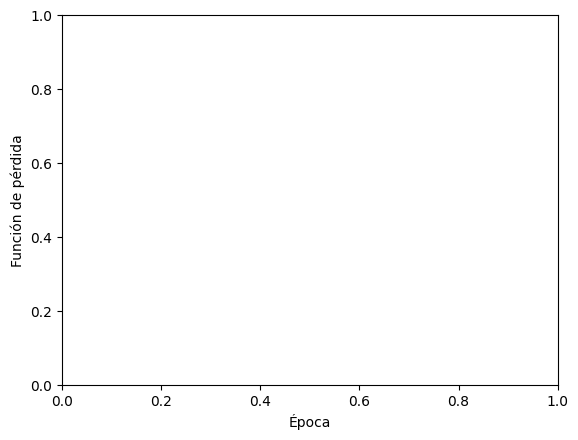

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Época")
plt.ylabel("Función de pérdida")
plt.plot(model_history.history["loss"])

# Modelo con el que se va a trabajar y modificar

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.activations import swish
from keras.layers import GlobalAveragePooling2D

# Inicializar la CNN
model = Sequential()

# Paso 1 - Capa de Convolución
model.add(Conv2D(16, (3, 3), padding='same', input_shape = (512, 512, 3), activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='valid', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='valid', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())

'''
model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (1, 1)))

model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (1, 1)))

model.add(BatchNormalization())

model.add(Conv2D(1024, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (1, 1)))

# Paso 3 - Flattening
model.add(Flatten())
'''

# GlobalAveragePooling2D en lugar de Flatten
model.add(GlobalAveragePooling2D())

# Paso 4 - Full connection
model.add(Dense(units = 256, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3)) # Reducir el dropout para evitar el sobreajuste
model.add(Dense(units = 1, activation = 'linear'))

# Compilar la CNN con un optimizador Adam ajustado
adam_optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer = adam_optimizer, loss = 'mean_absolute_error', metrics = ['mean_squared_error'])

# Ajustar el modelo a los datos de entrenamiento con un tamaño de lote adecuado
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
model_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, callbacks=[early_stopping])

# Modelo final

 Este es una nueva estructura mucho más reducida, los valores de pérdida son mas pequeños y se usa el huber como la función de pérdida, que toma las mejores características de las métricas del MAE y MSE

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import Huber
from keras.activations import swish
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay

# Inicializar la CNN
model = Sequential()

# Capas convolucionales
model.add(Conv2D(8, (10, 10), activation='swish', padding='same', input_shape=(512, 512, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(16, (10, 10), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (5, 5), activation='swish', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='swish', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Pooling global
model.add(GlobalAveragePooling2D())

# Capas densas
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

# Compilación
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
adam_optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=adam_optimizer, loss=Huber(delta=20.0), metrics=['mean_absolute_error'])

# Entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 603ms/step - loss: 992.0424 - mean_absolute_error: 57.7091 - val_loss: 782.8777 - val_mean_absolute_error: 48.0570
Epoch 2/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - loss: 506.7113 - mean_absolute_error: 33.7071 - val_loss: 1063.5321 - val_mean_absolute_error: 62.6352
Epoch 3/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - loss: 326.2931 - mean_absolute_error: 24.1989 - val_loss: 20605.2930 - val_mean_absolute_error: 1040.2632
Epoch 4/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - loss: 216.6296 - mean_absolute_error: 17.9236 - val_loss: 9597.6904 - val_mean_absolute_error: 489.8829
Epoch 5/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - loss: 167.6370 - mean_absolute_error: 15.4525 - val_loss: 855.4756 - val_mean_absolute_error: 51.4687
Epoch 6/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - loss: 171.6155 - mean_absolute_error: 15.5983 - val_loss: 8207.8750 - val_mean_absolute_error: 420.3921
Epoch 7/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 

# Analisis de épocas

Aquí veremos cómo varía la función de pérdida a través de la iteración en cada época. Si bien ya tenemos un earlystoping, ver la variación podría ser útil para realizar modificaciones en la arquitectura de la red

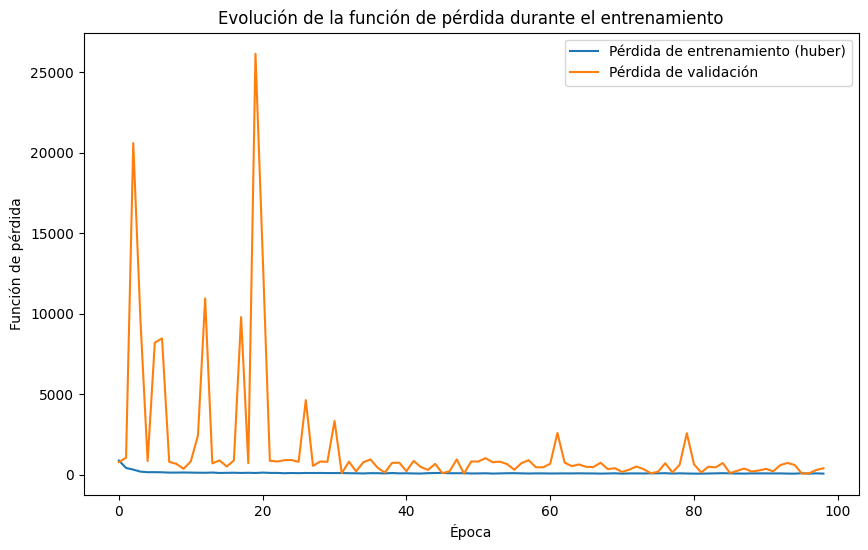

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.xlabel("Época")
plt.ylabel("Función de pérdida")
plt.plot(model_history.history["loss"], label="Pérdida de entrenamiento (huber)")
plt.plot(model_history.history["val_loss"], label="Pérdida de validación")

plt.legend()
plt.title("Evolución de la función de pérdida durante el entrenamiento")
plt.show()

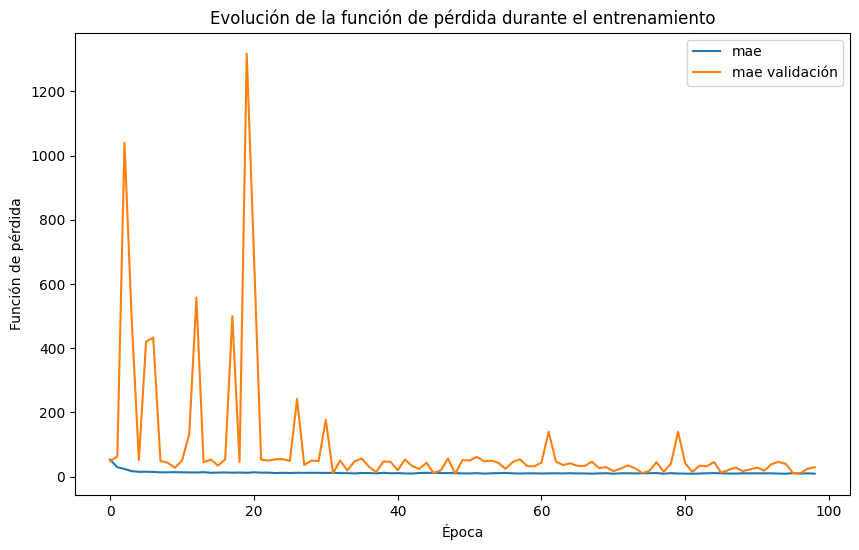

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.xlabel("Época")
plt.ylabel("Función de pérdida")
plt.plot(model_history.history["mean_absolute_error"], label="mae")
plt.plot(model_history.history["val_mean_absolute_error"], label="mae validación")

plt.legend()
plt.title("Evolución de la función de pérdida durante el entrenamiento")
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


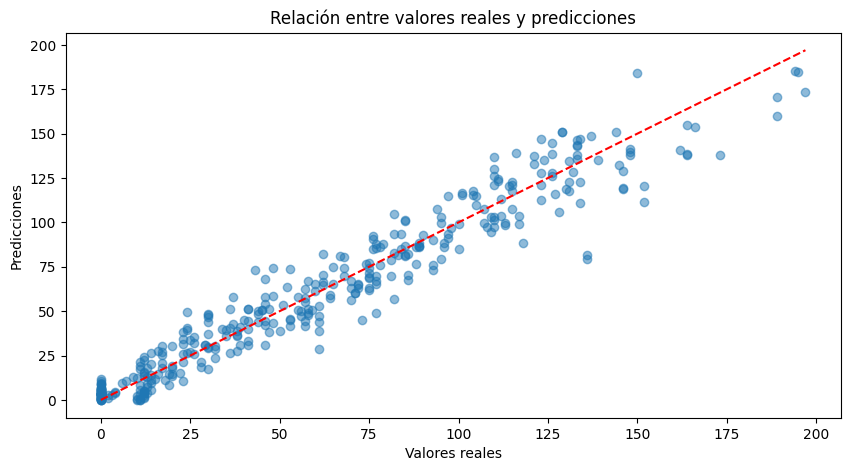

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Relación entre valores reales y predicciones')
plt.show()

# Pruebas con sklearn

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
# from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Preprocesar las imágenes
def preprocess_image(img):
    img = np.expand_dims(img, axis=0)  # Convertir de (H, W, C) a (1, H, W, C)
    img /= 255.0  # Normalización
    return img

# Obtener las predicciones sobre el conjunto de datos de prueba
predictions = model.predict(x_test)  # Usamos x_test para obtener las predicciones

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Imprimir las métricas
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'MAE: {mae}')


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
MSE: 143.62501314246487
RMSE: 11.984365362523993
R2 Score: 0.9396878563971821
MAE: 8.988057929923926


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


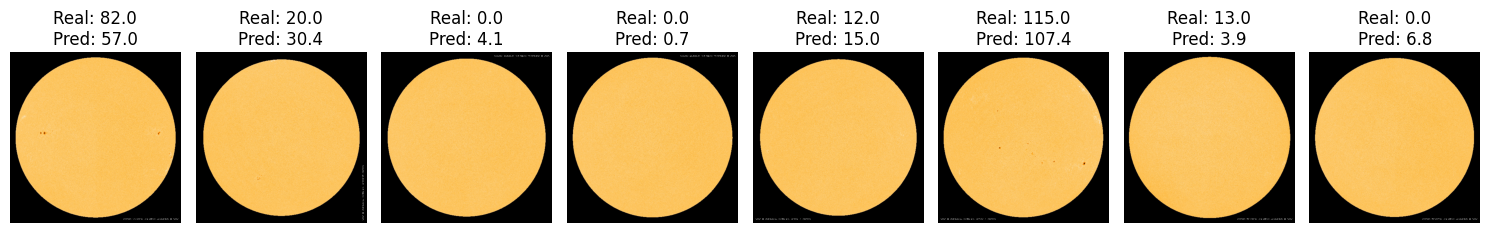

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Selecciona 4 índices aleatorios del conjunto de prueba
num_samples = 8
indices = random.sample(range(len(x_test)), num_samples)

# Toma las imágenes y etiquetas correspondientes
selected_images = x_test[indices]
true_labels = y_test[indices]

# Obtén las predicciones para las imágenes seleccionadas
predicted_labels = model.predict(selected_images)

# Configura el gráfico
plt.figure(figsize=(15, 8))

for i, idx in enumerate(indices):
    # Muestra la imagen
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(selected_images[i])
    plt.axis('off')

    # Agrega el título con los valores reales y predichos
    plt.title(f"Real: {true_labels[i]:.1f}\nPred: {predicted_labels[i][0]:.1f}", fontsize=12)

# Muestra el gráfico
plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


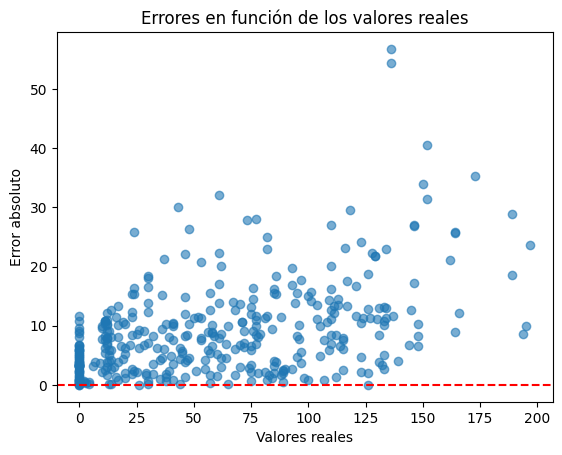

In [ ]:
errors = np.abs(y_test - model.predict(x_test).flatten())
plt.scatter(y_test, errors, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Error absoluto')
plt.title('Errores en función de los valores reales')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


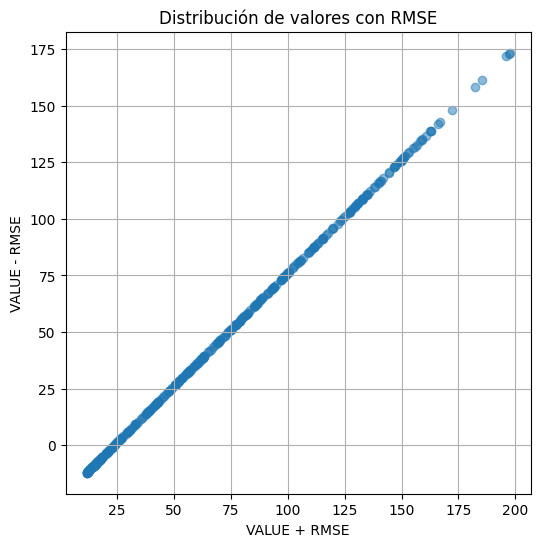

In [ ]:
# Obtener predicciones
y_pred = model.predict(x_test)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular los valores para los ejes
x_values = y_pred + rmse  # value + rmse
y_values = y_pred - rmse  # value - rmse

# Graficar
plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values, alpha=0.5)
plt.xlabel("VALUE + RMSE")
plt.ylabel("VALUE - RMSE")
plt.title("Distribución de valores con RMSE")
plt.grid(True)
plt.show()

In [ ]:
import keras
keras.saving.save_model(model, 'cnn_sn.keras')

# Legacy

## Para el entrenamiento inicial para pocos sunspots

In [ ]:
import os
import aiohttp
import asyncio
from bs4 import BeautifulSoup
import html5lib
import urllib.request

folder = 'training_images_4'
os.makedirs(folder, exist_ok=True)

async def download_image(sn_n, df_filtrado, folder):
    if df_filtrado.empty:
        print(f"No se encontraron datos para el número de mancha solar {sn_n}")
        return

    year = df_filtrado['year'].tolist()
    month = df_filtrado['month'].tolist()
    day = df_filtrado['day'].tolist()
    position_list = 0
    prev_year = year[0]
    folder2 = folder + "/" + str(sn_n)
    os.makedirs(folder2, exist_ok=True)

    tasks = []
    for i in year:
        base_url = "https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/"
        formatted_month = str(month[position_list]).zfill(2)
        formatted_day = str(day[position_list]).zfill(2)
        url = base_url + str(i) + "/hmiigr/" + str(i) + formatted_month + formatted_day + "/"
        cont = 0

        if position_list > 0 and prev_year == i:
            position_list += 1
            continue
        prev_year = i

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                html = await response.text()
                soup = BeautifulSoup(html, 'html5lib')
                imagelink = soup.find_all("a")
                position_list += 1

                if imagelink:
                    imagelink_2 = imagelink[5]['href']
                    url2 = url + imagelink_2
                    destination = os.path.join(folder2, imagelink_2)
                    task = asyncio.to_thread(urllib.request.urlretrieve, url2, destination)
                    print(f'[{sn_n}] Se guardó {imagelink_2} de {i}, {formatted_month}, {formatted_day}')
                    tasks.append(task)

    await asyncio.gather(*tasks)

async def main():
    tasks = [download_image(sn_n, df[df['sn number'] == sn_n], folder) for sn_n in range(10)]
    await asyncio.gather(*tasks)

# Ejecutar el bucle de eventos en Google Colab
import nest_asyncio
nest_asyncio.apply()
await main()

## Descarga un máximo de 15 imágenes con un número de sunspots de 0, 4 y 15

In [ ]:
'''
ESTE CÓDIGO ES SOLAMENTE MIENTRAS TENEMOS LAS PRUEBAS, NADA MÁS
'''

import os
import aiohttp
import asyncio
from bs4 import BeautifulSoup
import html5lib
import urllib.request

folder = 'training_images_3'
os.makedirs(folder, exist_ok=True)

async def download_image(sn_n, df_filtrado, folder, max_images=15):
    if df_filtrado.empty:
        print(f"No se encontraron datos para el número de mancha solar {sn_n}")
        return

    year = df_filtrado['year'].tolist()
    month = df_filtrado['month'].tolist()
    day = df_filtrado['day'].tolist()
    position_list = 0
    prev_year = year[0]
    folder2 = folder + "/" + str(sn_n)
    os.makedirs(folder2, exist_ok=True)

    tasks = []
    image_count = 0
    for i in year:
        if sn_n not in [0, 4, 7]:
            break

        base_url = "https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/"
        formatted_month = str(month[position_list]).zfill(2)
        formatted_day = str(day[position_list]).zfill(2)
        url = base_url + str(i) + "/hmiigr/" + str(i) + formatted_month + formatted_day + "/"
        cont = 0

        if position_list > 0 and prev_year == i:
            position_list += 1
            continue
        prev_year = i

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                html = await response.text()
                soup = BeautifulSoup(html, 'html5lib')
                imagelink = soup.find_all("a")
                position_list += 1

                if imagelink:
                    imagelink_2 = imagelink[5]['href']
                    url2 = url + imagelink_2
                    destination = os.path.join(folder2, imagelink_2)
                    task = asyncio.to_thread(urllib.request.urlretrieve, url2, destination)
                    print(f'[{sn_n}] Se guardó {imagelink_2} de {i}, {formatted_month}, {formatted_day}')
                    tasks.append(task)
                    image_count += 1
                    if image_count >= max_images:
                        break

    await asyncio.gather(*tasks)

async def main():
    sunspots_to_process = [0, 4, 7]
    tasks = [download_image(sn_n, df[df['sn number'] == sn_n], folder, max_images=15) for sn_n in sunspots_to_process]
    await asyncio.gather(*tasks)

# Ejecutar el bucle de eventos en Google Colab
import nest_asyncio
nest_asyncio.apply()
await main()

[121] Se guardó 20220402_000000_Ic_flat_1k.jpg de 2022, 04, 02
[10] Se guardó 20210411_000000_Ic_flat_1k.jpg de 2021, 04, 11
[124] Se guardó 20140101_000000_Ic_flat_1k.jpg de 2014, 01, 01
[166] Se guardó 20230530_000000_Ic_flat_1k.jpg de 2023, 05, 30
[143] Se guardó 20240214_000000_Ic_flat_1k.jpg de 2024, 02, 14
[139] Se guardó 20140320_000000_Ic_flat_1k.jpg de 2014, 03, 20
[102] Se guardó 20140820_000000_Ic_flat_1k.jpg de 2014, 08, 20
[153] Se guardó 20230325_000000_Ic_flat_1k.jpg de 2023, 03, 25
[62] Se guardó 20131123_000000_Ic_flat_1k.jpg de 2013, 11, 23
[37] Se guardó 20160101_000000_Ic_flat_1k.jpg de 2016, 01, 01
[33] Se guardó 20160321_000000_Ic_flat_1k.jpg de 2016, 03, 21
[165] Se guardó 20230719_000000_Ic_flat_1k.jpg de 2023, 07, 19
[16] Se guardó 20161222_000000_Ic_flat_1k.jpg de 2016, 12, 22
[57] Se guardó 20121224_000000_Ic_flat_1k.jpg de 2012, 12, 24
[46] Se guardó 20160414_000000_Ic_flat_1k.jpg de 2016, 04, 14
[86] Se guardó 20141108_000000_Ic_flat_1k.jpg de 2014, 11, 08


In [ ]:
import os

# Imprime la lista de archivos en la carpeta
print(os.listdir('/content/training_images_5'))


['64', '133', '56', '98', '90', '18', '102', '123', '73', '109', '141', '143', '76', '154', '167', '48', '140', '193', '197', '5', '34', '125', '69', '71', '210', '192', '74', '21', '58', '161', '6', '82', '60', '83', '163', '53', '159', '121', '144', '176', '25', '79', '171', '87', '110', '15', '46', '111', '200', '155', '47', '27', '187', '120', '205', '54', '204', '17', '10', '153', '42', '49', '206', '177', '37', '7', '136', '51', '168', '158', '68', '182', '88', '164', '78', '41', '217', '20', '195', '160', '92', '186', '113', '185', '169', '77', '29', '36', '129', '151', '35', '75', '52', '30', '150', '22', '84', '149', '40', '9', '91', '38', '101', '66', '131', '162', '180', '117', '178', '198', '132', '179', '106', '174', '127', '63', '139', '124', '115', '28', '103', '104', '188', '0', '207', '95', '114', '13', '157', '107', '172', '146', '119', '2', '70', '122', '44', '126', '32', '199', '220', '62', '31', '93', '86', '165', '50', '228', '65', '181', '4', '175', '81', '108', 

## Arquitectura vieja

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.activations import swish

# Inicializar la CNN
model = Sequential()

# Paso 1 - Capa de Convolución
model.add(Conv2D(16, (3, 3), padding='same', input_shape = (256, 256, 3), activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), padding='valid', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), padding='valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3), padding='valid', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (1, 1)))

model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (1, 1)))

model.add(Conv2D(1024, (3, 3), padding='same', activation = 'swish'))
model.add(MaxPooling2D(pool_size = (1, 1)))

# Paso 3 - Flattening
model.add(Flatten())

# Paso 4 - Full connection
model.add(Dense(units = 1024, activation = 'relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.1)) # Reducir el dropout para evitar el sobreajuste
model.add(Dense(units = 1, activation = 'linear'))

# Compilar la CNN con un optimizador Adam ajustado
adam_optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer = adam_optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

# Ajustar el modelo a los datos de entrenamiento con un tamaño de lote adecuado
early_stopping = EarlyStopping(monitor='loss', patience=30)
model.fit(generator, epochs=1000, callbacks=[early_stopping])

## Autoentrenamiento


In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
#Para correr la siguiente celda se necesita ejecutar esta. Son funciones e información almacenada en otros bloques, pero evita tener que ejecutar el resto
#del colab
import numpy as np
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i+2}_filters', min_value=32, max_value=128, step=32),
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_mean_absolute_error',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


#Crear x_val y y_val
img_paths = ['/content/training_images_3/0/20160603_000000_Ic_flat_1k.jpg', '/content/training_images_3/4/20200107_000000_Ic_flat_1k.jpg', '/content/training_images_3/7/20220607_000000_Ic_flat_1k.jpg']
x_val= []
for img in img_paths:
  x_val.append(preprocess_image(img))

y_val = [0, 4, 7]  # Valores reales de sunspots


#Se utiliza el generador creado en uno de los bloques anteriores

tuner.search(generator, epochs=10, validation_data=(x_val, y_val))


Reloading Tuner from my_dir/intro_to_kt/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1_filters
3                 |3                 |num_conv_layers
32                |32                |conv_2_filters
256               |256               |dense_units
0.3               |0.4               |dropout
0.001             |0.001             |learning_rate
32                |32                |conv_3_filters
32                |32                |conv_4_filters
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 18.4088 - mean_absolute_error: 3.3561

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/eng

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/__init__.py", line 120, in get_data_adapter
    raise ValueError(f"Unrecognized data type: x={x} (of type {type(x)})")
ValueError: Unrecognized data type: x=[array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32), array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32), array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)] (of type <class 'list'>)
